In [1]:
import pandas as pd
import numpy as np
import os
import shapefile
from bokeh.plotting import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# print gpd.__version__
sns.set_style('white')

# from bokeh.plotting import patches
from geopy.geocoders import Nominatim
geolocator = Nominatim()

# pylab.rcParams['figure.figsize'] = (10.0, 8.0)
# location = geolocator.geocode("Chicago Illinois")

In [15]:
# !pip install libgdal-dev

  Could not find a version that satisfies the requirement libgdal-dev (from versions: )
No matching distribution found for libgdal-dev
You are using pip version 9.0.2, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# !pip install -U geoplot

In [2]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
fs={'figsize':(10,8)}

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=14)
matplotlib.rc('legend', fontsize=13)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rc('font', **font)
matplotlib.rc('figure',**fs)

In [3]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [4]:
from math import sqrt
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{cmbright}'],
              'axes.labelsize': 16, # fontsize for x and y labels (was 10)
              'axes.titlesize': 18,
#               'text.fontsize': 16, # was 10
              'legend.fontsize': 16, # was 10
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [5]:
# Slightly changed version from http://nbviewer.jupyter.org/gist/jorisvandenbossche/d4e6efedfa1e4e91ab65
# from geopandas.plotting import *
from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)
def __pysal_choro(values, scheme, k=5):
    """ Wrapper for choropleth schemes from PySAL for use with plot_dataframe

        Parameters
        ----------

        values
            Series to be plotted

        scheme
            pysal.esda.mapclassify classificatin scheme ['Equal_interval'|'Quantiles'|'Fisher_Jenks']

        k
            number of classes (2 <= k <=9)

        Returns
        -------

        values
            Series with values replaced with class identifier if PySAL is available, otherwise the original values are used
    """

    try:
        from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        s0 = scheme
        scheme = scheme.lower()
        if scheme not in schemes:
            scheme = 'quantiles'
            print('Unrecognized scheme: ', s0)
            print('Using Quantiles instead')
        if k < 2 or k > 9:
            print('Invalid k: ', k)
            print('2<=k<=9, setting k=5 (default)')
            k = 5
        binning = schemes[scheme](values, k)
        values = binning.yb
    except ImportError:
        print('PySAL not installed, setting map to default')

    return binning

# adding linewidth parameter

def plot_polygon(ax, poly, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)

def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1, legend_loc='best', legend_ncol=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        
#         cmap=sns.color_palette("Reds")
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            #print value
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=1,color='k',
                                          markersize=10, markerfacecolor=cmap.to_rgba(value)))
                legend = ax.legend(fancybox=True, shadow=True)
                ax.legend(patches, categories, numpoints=1, loc='upper center',
                          bbox_to_anchor=(0.5, -0.05), ncol=legend_ncol,shadow=True,fancybox=True)
#                 l2.get_frame().set_facecolor('#00FFCC')

            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

ImportError: cannot import name plot_linestring

In [7]:
def merge_shp_data(shp_file_path, data_file_path,colName='PercentageWithAccess' ,sep=',', index_col='ADMIN'):
    imd = gpd.read_file(shp_file_path).set_index(index_col)
    final_plot_df=pd.read_csv(data_file_path, delimiter=sep)
    
    print final_plot_df.head()
    final_plot_df=final_plot_df[[index_col,colName]]
    final_plot_df.head()
#     final_plot_df=final_plot_df[[index_col,colName]]

    final_plot_df.set_index(index_col, inplace=True)
    final_plot_df=final_plot_df.dropna()
    final_plot_df.head(2)
    imd=imd.join(final_plot_df, how='left')
    imd.fillna(-1, inplace=True)
    return imd


# Ghana

In [8]:
# os.chdir('F://MobileMoneyPaper//Maps//TIGO2_Maps//')

In [9]:
# new_df=pd.read_csv('TIGO2_CellId_with_DistrictNames.csv')
# new_df=new_df.sort_values(by=['LATITUDE','LONGITUDE'])
# new_df.head()
# new_df.to_csv('sorted_TIGO2_CellId_with_DistrictNames.csv')

In [10]:
# new_df=pd.read_csv('sorted_TIGO2_CellId_with_DistrictNames.csv')
# dist1=list(new_df.ADMIN_NAME.unique())
# dist2=list(imd.ADMIN_NAME.unique())
# for each in dist1:
#     if each not in dist2:
#         print each, ' ',
        
# print new_df[pd.isnull(new_df).any(axis=1)]

# Voice Subscribers Distribution

In [11]:
data_file_path='Voice_Subscribers_per_district.csv'
shp_file_path='geo2_gh2010b.shp'
imd = gpd.read_file(shp_file_path)

v_df=pd.read_csv(data_file_path)

v_df['Voice_Subscribers_Percentage']=v_df['SubscribersCount']*100/v_df['SubscribersCount'].sum()
v_df.head()
v_df.to_csv(data_file_path)
# print imd.head()
# sorted(imd.ADMIN_NAME.unique())
#Correct bodi:juabeso

In [12]:
merged_data=merge_shp_data( shp_file_path,data_file_path,colName='Voice_Subscribers_Percentage', index_col='ADMIN_NAME')
merged_data.head()

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   
2           2             2               2                 2   
3           3             3               3                 3   
4           4             4               4                 4   

   Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                   0                     0                       0   
1                   1                     1                       1   
2                   2                     2                       2   
3                   3                     3                       3   
4                   4                     4                       4   

   Unnamed: 0.1.1.1.1.1.1.1  Unnamed: 0.1.1.2           ADMIN_NAME  \
0                         0                 0               Karaga   
1                         1               

,CNTRY_NAME,CNTRY_CODE,IPUM2010,DIST2010,PARENT,geometry,Voice_Subscribers_Percentage
ADMIN_NAME,,,,,,,
Jomoro,Ghana,288,001001,101,001,"POLYGON ((-2.608762422999972 5.41338551300011,...",0.659174
Ellembelle,Ghana,288,001002,102,001,POLYGON ((-2.458923206999947 5.386276182000168...,0.614034
Nzema East,Ghana,288,001003,103,001,(POLYGON ((-2.24836111137599 4.856222153229991...,0.178286
Ahanta West,Ghana,288,001004,104,001,(POLYGON ((-1.931666612823779 4.79788875556175...,0.707338
Sekondi-Takoradi,Ghana,288,001005,105,001,POLYGON ((-1.725173642999948 5.042976319000104...,4.363000


In [13]:
# !pip install -U geoplot --user

NameError: global name 'norm_cmap' is not defined

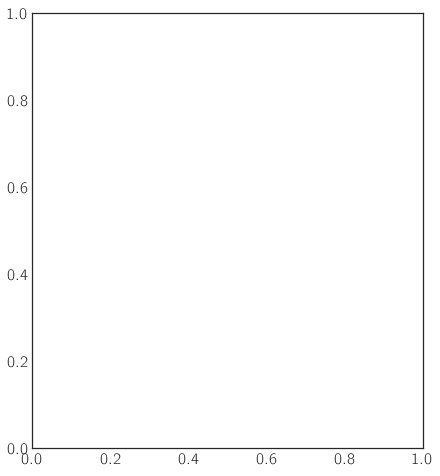

In [14]:
latexify(fig_width=7,fig_height=8)
f, ax = plt.subplots(1)
colors = [(0.5,0.5,0.5),(0.8,0,0),(0.2,0,1)]
### Create an array or list of positions from 0 to 1.
position = [0,0.1,  1]
ccmap=make_cmap(colors, position=position)
ax=plot_dataframe(merged_data,column='Voice_Subscribers_Percentage' ,axes=ax,scheme='fisher_jenks',#'fisher_jenks', 
         alpha=1, legend=True, k=8,colormap=plt.cm.Reds, legend_loc='upper right',legend_ncol=3)
# ax.set_ylabel("Latitude", fontsize=18)
# ax.set_xlabel("Longitude", fontsize=18)
# ax.set_xticklabels(ax.get_xticklabels(),fontsize=18, fontweight='bold')
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=18, fontweight='bold')
ax.legend(loc='upper right')
# ax.xlim(-3.5,)
# imd.plot(column='GenderParityScore' ,axes=ax,scheme='equal_interval',#'fisher_jenks', 
#          alpha=0.8, legend=True, k=7,colormap=plt.cm.Greens)
#cbar = plt.colorbar(cmap, cax=cax, **kw)
# plt.legend(shadow=True, fancybox=True)
plt.show()
f.savefig('Ghana_Voice_Distribution.png', bbox_inches='tight')

# Mobile Money Subscribers Distribution

In [40]:
data_file_path='MobileMoneyUsers_per_District.csv'
shp_file_path='geo2_gh2010.shp'
imd = gpd.read_file(shp_file_path)

v_df=pd.read_csv(data_file_path)

v_df['MM_Subscribers_Percentage']=v_df['MM_Count']*100/v_df['MM_Count'].sum()
v_df.head()
v_df.to_csv(data_file_path)
# print imd.head()
# sorted(imd.ADMIN_NAME.unique())
#Correct bodi:juabeso

In [41]:
merged_data=merge_shp_data( shp_file_path,data_file_path,colName='MM_Subscribers_Percentage', index_col='ADMIN_NAME')
merged_data.head()

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1           ADMIN_NAME  MM_Count  \
0           0             0             0               Karaga      1279   
1           1             1             1  Kasena Nankana East       968   
2           2             2             2                Yendi      2404   
3           3             3             3              Juabeso      3749   
4           4             4             4           Kwahu East      5953   

   MM_Subscribers_Percentage  
0                   0.048485  
1                   0.036695  
2                   0.091132  
3                   0.142119  
4                   0.225669  


,CNTRY_CODE,CNTRY_NAME,DIST2010,IPUM2010,PARENT,geometry,MM_Subscribers_Percentage
ADMIN_NAME,,,,,,,
Jomoro,288,Ghana,101,001001,001,"POLYGON ((-2.608762422999972 5.41338551300011,...",0.651835
Ellembelle,288,Ghana,102,001002,001,POLYGON ((-2.458923206999947 5.386276182000168...,0.649637
Nzema East,288,Ghana,103,001003,001,(POLYGON ((-2.24836111137599 4.856222153229991...,0.117592
Ahanta West,288,Ghana,104,001004,001,(POLYGON ((-1.931666612823779 4.79788875556175...,0.826442
Sekondi-Takoradi,288,Ghana,105,001005,001,POLYGON ((-1.725173642999948 5.042976319000104...,5.596421


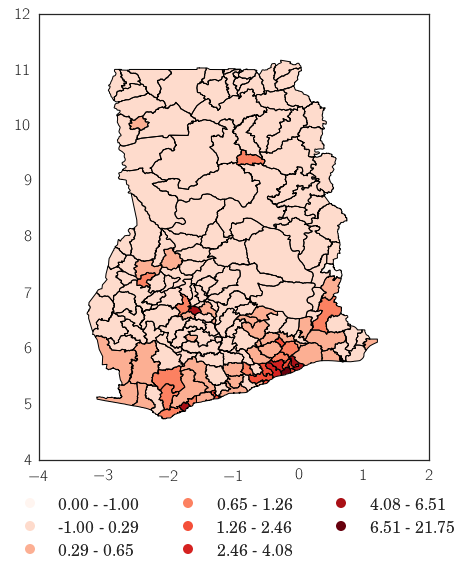

In [42]:
latexify(fig_width=7,fig_height=8)
f, ax = plt.subplots(1)
colors = [(0,0.5,0.5),(1,0,0),(1,0,1)]
### Create an array or list of positions from 0 to 1.
position = [0,0.1,  1]
ccmap=make_cmap(colors, position=position)
ccmap = sns.cubehelix_palette(8, start=2.5, rot=-.75)
ax=plot_dataframe(merged_data,column='MM_Subscribers_Percentage' ,axes=ax,scheme='fisher_jenks',#'Quantiles',#'fisher_jenks', 
         alpha=1, legend=True, k=8,colormap=plt.cm.Reds, legend_loc='upper right',legend_ncol=3)
# ax.set_ylabel("Latitude", fontsize=18)
# ax.set_xlabel("Longitude", fontsize=18)
# ax.set_xticklabels(ax.get_xticklabels(),fontsize=18, fontweight='bold')
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=18, fontweight='bold')
ax.legend(loc='upper right')
# ax.xlim(-3.5,)
# imd.plot(column='GenderParityScore' ,axes=ax,scheme='equal_interval',#'fisher_jenks', 
#          alpha=0.8, legend=True, k=7,colormap=plt.cm.Greens)
#cbar = plt.colorbar(cmap, cax=cax, **kw)
# plt.legend(shadow=True, fancybox=True)
plt.show()
f.savefig('Ghana_MM_Distribution.png', bbox_inches='tight')

# Adoption_Probabilities

In [47]:
data_file_path='Merged_Adoption_Probs.csv'
v_df=pd.read_csv(data_file_path)
v_df=pd.DataFrame(v_df.groupby(['ADMIN_NAME'])['p1'].mean()).reset_index()
v_df.columns=['ADMIN_NAME','MEAN_Adoption_Score']
v_df.head()
v_df.to_csv('Merged_Adoption_Probs_per_District.csv')

In [44]:
shp_file_path='geo2_gh2010.shp'
imd = gpd.read_file(shp_file_path)
print v_df.head()


               ADMIN_NAME  MEAN_Adoption_Score
0                   A M A             0.152031
1  Abura-Asebu-Kwamankese             0.151496
2          Adaklu Anyigbe             0.153541
3            Adansi North             0.151568
4            Adansi South             0.153805


In [48]:
merged_data=merge_shp_data( shp_file_path,data_file_path='Merged_Adoption_Probs_per_District.csv',
                           colName='MEAN_Adoption_Score', index_col='ADMIN_NAME')
merged_data.head()

   Unnamed: 0              ADMIN_NAME  MEAN_Adoption_Score
0           0                   A M A             0.152031
1           1  Abura-Asebu-Kwamankese             0.151496
2           2          Adaklu Anyigbe             0.153541
3           3            Adansi North             0.151568
4           4            Adansi South             0.153805


,CNTRY_CODE,CNTRY_NAME,DIST2010,IPUM2010,PARENT,geometry,MEAN_Adoption_Score
ADMIN_NAME,,,,,,,
Jomoro,288,Ghana,101,001001,001,"POLYGON ((-2.608762422999972 5.41338551300011,...",0.153003
Ellembelle,288,Ghana,102,001002,001,POLYGON ((-2.458923206999947 5.386276182000168...,0.152583
Nzema East,288,Ghana,103,001003,001,(POLYGON ((-2.24836111137599 4.856222153229991...,0.151568
Ahanta West,288,Ghana,104,001004,001,(POLYGON ((-1.931666612823779 4.79788875556175...,0.152651
Sekondi-Takoradi,288,Ghana,105,001005,001,POLYGON ((-1.725173642999948 5.042976319000104...,0.152216


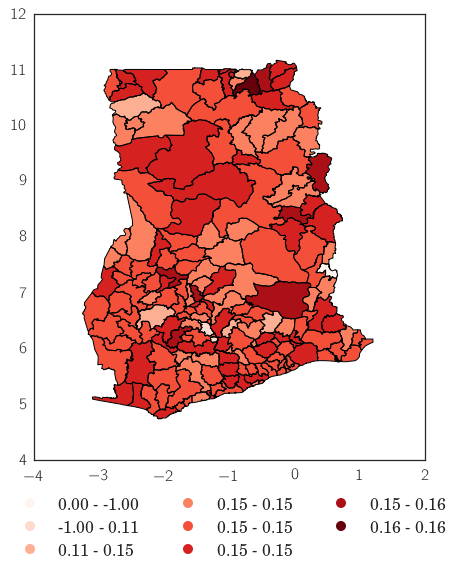

In [49]:
latexify(fig_width=7,fig_height=8)
f, ax = plt.subplots(1)
colors = [(0,0.5,0.5),(1,0,0),(1,0,1)]
### Create an array or list of positions from 0 to 1.
position = [0,0.1,  1]
ccmap=make_cmap(colors, position=position)
ccmap = sns.cubehelix_palette(8, start=2.5, rot=-.75)
ax=plot_dataframe(merged_data,column='MEAN_Adoption_Score' ,axes=ax,scheme='fisher_jenks',#'Quantiles',#'fisher_jenks', 
         alpha=1, legend=True, k=8,colormap=plt.cm.Reds, legend_loc='upper right',legend_ncol=3)
# ax.set_ylabel("Latitude", fontsize=18)
# ax.set_xlabel("Longitude", fontsize=18)
# ax.set_xticklabels(ax.get_xticklabels(),fontsize=18, fontweight='bold')
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=18, fontweight='bold')
ax.legend(loc='upper right')
# ax.xlim(-3.5,)
# imd.plot(column='GenderParityScore' ,axes=ax,scheme='equal_interval',#'fisher_jenks', 
#          alpha=0.8, legend=True, k=7,colormap=plt.cm.Greens)
#cbar = plt.colorbar(cmap, cax=cax, **kw)
# plt.legend(shadow=True, fancybox=True)
plt.show()
f.savefig('Ghana_MMAdoption_Distribution.png', bbox_inches='tight')

In [50]:
v_df.head()

,ADMIN_NAME,MEAN_Adoption_Score
0,A M A,0.152031
1,Abura-Asebu-Kwamankese,0.151496
2,Adaklu Anyigbe,0.153541
3,Adansi North,0.151568
4,Adansi South,0.153805


# Cell Level Adoption

In [51]:
probs_df=pd.read_csv('Merged_Adoption_Probs.csv')
probs_df=probs_df.rename(columns={'ModalCell':'CGI'})
towers_df=pd.read_csv('sorted_TIGO2_CellId_with_DistrictNames.csv')
print probs_df.head()
print towers_df.head()

   predict        p0        p1      CallerId    CGI        ADMIN_NAME
0        0  0.898298  0.101702  233271690351  30051              Tema
1        1  0.698165  0.301835  233277426877  20293             A M A
2        1  0.675578  0.324422  233274872002  59452            Effutu
3        0  0.819701  0.180299  233577681697  19713              Tema
4        0  0.910957  0.089043  233274254812  11863  Weija (Ga South)
   Unnamed: 0    CGI  LATITUDE  LONGITUDE   Region     District   ADMIN_NAME
0        4795  36241   4.79141   -2.13351  Western  AHANTA WEST  Ahanta West
1        4796  36242   4.79141   -2.13351  Western  AHANTA WEST  Ahanta West
2        4797  36243   4.79141   -2.13351  Western  AHANTA WEST  Ahanta West
3         628  13761   4.81056   -1.94221  Western  AHANTA WEST  Ahanta West
4         629  13762   4.81056   -1.94221  Western  AHANTA WEST  Ahanta West


In [103]:
towers_df=towers_df[['CGI','LATITUDE','LONGITUDE']]

towers_probs=pd.merge(probs_df, towers_df, on='CGI')

towers_probs=pd.DataFrame(towers_probs.groupby(['CGI','LATITUDE','LONGITUDE'])['p1'].mean()).reset_index()
# type(towers_probs)
print towers_probs['p1'].describe()

print towers_probs['LATITUDE'].mean()

print towers_probs['LONGITUDE'].mean()

noise = np.random.normal(1e-6,1e-3,towers_probs.shape[0])

lats=list(towers_probs['LATITUDE']+noise)
longs=list(towers_probs['LONGITUDE']+noise)
towers=list(towers_probs['CGI'])
probs=list(towers_probs['p1'])
towers_probs=[str(int(x))+','+str(round(y,3)) for x,y in zip(towers,probs) ]
cat_probs=[]
for x in probs:
    if x>0.15:
        cat_probs.append(2)
    elif x>0.14:
        cat_probs.append(1)
    else:
        cat_probs.append(0)
# probs_mean=np.mean(probs)
# probs_max=np.max(probs)
# probs2=[(x)*10/probs_max for x in probs]
# probs2

count    7744.000000
mean        0.151741
std         0.019423
min         0.031338
25%         0.144830
50%         0.151504
75%         0.157855
max         0.564719
Name: p1, dtype: float64
6.15470113895
-0.838281283288


In [133]:
from bokeh.io import output_file, show
from bokeh.palettes import RdYlGn10 as palette 
from collections import OrderedDict
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d,HoverTool,Legend, PanTool, WheelZoomTool, BoxSelectTool
)
# from bokeh.core.enums import LegendLocation

# Create the color mapper
colormap = {0:"Yellow",1:"OrangeRed",2:"DarkRed"}

colors = [colormap[x] for x in cat_probs]


map_options = GMapOptions(lat=7.15470113895, lng=-0.938281283288, map_type="roadmap", zoom=7)

plot = GMapPlot(x_range=Range1d(), y_range=Range1d(), map_options=map_options)
plot.title = "Ghana"

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:
# plot.api_key = "GOOGLE_API_KEY"

source = ColumnDataSource(
    data=dict(
        lat=lats,
        lon=longs,
        probs=probs,
        towers=towers,
        towers_probs=towers_probs,
        colors=colors
    )
)

circle = Circle(x="lon", y="lat", size=3, fill_color="colors", fill_alpha=0.5, line_color="colors")
plot.add_glyph(source, circle)

plot.add_tools(PanTool(), WheelZoomTool(),HoverTool())#, BoxSelectTool())

phover = plot.select(dict(type=HoverTool))

# phover = HoverTool(renderers=[circle])
# phover.tooltips=[("Tower", "@towers")]
phover.tooltips = OrderedDict([
    ("Tower,AvgProb", "@towers_probs"),
])


def add_legend(location, orientation, side):
    legend = Legend(
        # TODO: title
        name=("Red", [circle]),
        orientation=orientation,
        
    )
    plot.add_layout(legend, side)


# Add legend at fixed positions
add_legend((150, 50), "top_right", "center")

# plot.add_tools(phover)
output_file("gmap_plot.html")
show(plot)

ValueError: expected a value of type basestring, got ('Red', [<bokeh.models.markers.Circle object at 0x0000000029F56780>]) of type tuple

# Active Adoption

In [134]:
data_file_path='Merged_ActiveAdoption_Probs.csv'
v_df=pd.read_csv(data_file_path)
v_df=pd.DataFrame(v_df.groupby(['ADMIN_NAME'])['p1'].mean()).reset_index()
v_df.columns=['ADMIN_NAME','MEAN_Adoption_Score']
v_df.head()
v_df.to_csv('Merged_ActiveAdoption_Probs_per_District.csv')

In [135]:
shp_file_path='geo2_gh2010.shp'
imd = gpd.read_file(shp_file_path)
print v_df.head()


               ADMIN_NAME  MEAN_Adoption_Score
0                   A M A             0.436730
1  Abura-Asebu-Kwamankese             0.440864
2          Adaklu Anyigbe             0.430254
3            Adansi North             0.423198
4            Adansi South             0.435248


In [136]:
merged_data=merge_shp_data( shp_file_path,data_file_path='Merged_ActiveAdoption_Probs_per_District.csv',
                           colName='MEAN_Adoption_Score', index_col='ADMIN_NAME')
merged_data.head()

   Unnamed: 0              ADMIN_NAME  MEAN_Adoption_Score
0           0                   A M A             0.436730
1           1  Abura-Asebu-Kwamankese             0.440864
2           2          Adaklu Anyigbe             0.430254
3           3            Adansi North             0.423198
4           4            Adansi South             0.435248


,CNTRY_CODE,CNTRY_NAME,DIST2010,IPUM2010,PARENT,geometry,MEAN_Adoption_Score
ADMIN_NAME,,,,,,,
Jomoro,288,Ghana,101,001001,001,"POLYGON ((-2.608762422999972 5.41338551300011,...",0.433579
Ellembelle,288,Ghana,102,001002,001,POLYGON ((-2.458923206999947 5.386276182000168...,0.438755
Nzema East,288,Ghana,103,001003,001,(POLYGON ((-2.24836111137599 4.856222153229991...,0.414822
Ahanta West,288,Ghana,104,001004,001,(POLYGON ((-1.931666612823779 4.79788875556175...,0.443603
Sekondi-Takoradi,288,Ghana,105,001005,001,POLYGON ((-1.725173642999948 5.042976319000104...,0.451921


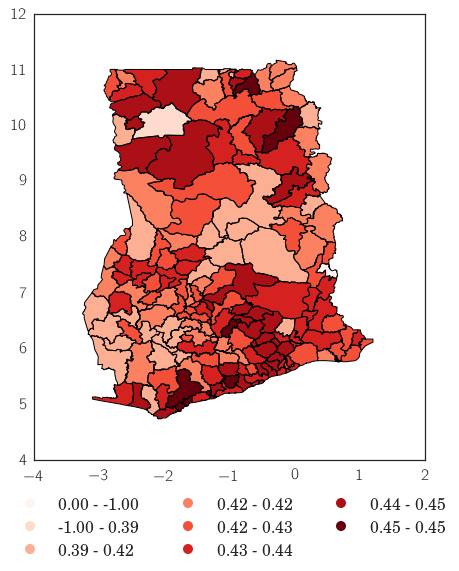

In [137]:
latexify(fig_width=7,fig_height=8)
f, ax = plt.subplots(1)
colors = [(0,0.5,0.5),(1,0,0),(1,0,1)]
### Create an array or list of positions from 0 to 1.
position = [0,0.1,  1]
ccmap=make_cmap(colors, position=position)
ccmap = sns.cubehelix_palette(8, start=2.5, rot=-.75)
ax=plot_dataframe(merged_data,column='MEAN_Adoption_Score' ,axes=ax,scheme='fisher_jenks',#'Quantiles',#'fisher_jenks', 
         alpha=1, legend=True, k=8,colormap=plt.cm.Reds, legend_loc='upper right',legend_ncol=3)
# ax.set_ylabel("Latitude", fontsize=18)
# ax.set_xlabel("Longitude", fontsize=18)
# ax.set_xticklabels(ax.get_xticklabels(),fontsize=18, fontweight='bold')
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=18, fontweight='bold')
ax.legend(loc='upper right')
# ax.xlim(-3.5,)
# imd.plot(column='GenderParityScore' ,axes=ax,scheme='equal_interval',#'fisher_jenks', 
#          alpha=0.8, legend=True, k=7,colormap=plt.cm.Greens)
#cbar = plt.colorbar(cmap, cax=cax, **kw)
# plt.legend(shadow=True, fancybox=True)
plt.show()
f.savefig('Ghana_MMActiveAdoption_Distribution.png', bbox_inches='tight')